<h1>LightMat Tutorial: Potential for hyperfine atom in arbitrary laser light field</h1>

In this tutorial, it is shown how to create a laser setup with some beams and a hyperfine atom in LightMat. Then the potential is calculated for some (x,y,z)-values and returned as a 3d array. This can be visually presented with an interactive plot, where one can view the potential in the xy-, xz- or yz-plane with the third coordinate fixed, but changeable. It can be selected either as 2d color plot or as 3d surface plot. The potential can also be viewed in 1d along x-, y-, or z-direction with the other two coordinates fixed, but changeable.

In [1]:
from LightMat import GaussianBeam, Lattice1d, BowtieLattice2d, Atom, LaserSetup, interactive_plot
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

<h3>Set up lasers</h3>
First, let us define a Gaussian beam! By hovering over the GaussianBeam() class, one can see a brief description and all the arguments, that need to be provided.

For example, let us define a very elliptical 1064nm lightsheet beam propagating along x-direction with beam waist of only 10um along z-direction for strong z-confinement.

In [2]:
lightsheet = GaussianBeam(
    beam_direction_vec=(1,0,0), # propagation direction of the Gaussian beam (does not need to be normalized, will be normalized automatically)
    lambda_ = 1064 * u.nm,  # astropy.Quantity in units of length or float (then it is assumed in [nm])
    w0 = [300, 10] * u.um, # Can be scalar for circular beams or sequence of 2 scalars for elliptical beams
    P = 3 * u.W,
    pol_Jones_vec='linear horizontal', # Either string from ['linear horizontal', 'linear vertical', 'circular right', 'circular left'] 
                                       # or arbitrary 2d vector, e.g. pol_Jones_vec=(1,1)
    z0=0*u.um, # this does not need to be provided, default is already 0
    name='Lightsheet', # default is 'Gaussian Beam'. The name will become visible later as plot label
)


We can also define a Laser(), which can have several beams that are all interfering with each other. One can either directly instantiate a Laser() by passing a sequence of beams, but there are also specific lasers inheriting from the general Laser() class. A particular laser is for example Lattice1d(), which has two counter-propagating beams with a certain intersection angle.

Let us now define a shallow-angle 1d lattice along z-direction with two beams intersecting at an angle of 165° (where 0° means counter-propagating and 180° means propagation in the same direction).

In [3]:
lattice_z = Lattice1d(
    lattice_direction_vec=(0,0,1), # direction along which the lattice sites are forming
    intersect_angle=165, # intersection angle of the two beams in [deg] by which they are rotated away from counter-propagating along lattice_direction_vec
    intersect_axis=(0,1,0), # the axis around which the two beams are rotated away from counter-propagation
    lambda_=866, # either float (assumed in [nm]) or astropy.Quantity
    w0=50*u.um, # the beam waist of the two beams, could also be 2d vector (w0x, w0y) for elliptical beams or list of two 2d vectors for different beam 
                # waists of the two lattice beams
    P=0.5*u.W, # power of the two beams. Can also be 2d vector if the beams should have different power.
    pol_Jones_vec=(1,0), # just as in GaussianBeam, here (1,0) is the same as 'linear horizontal'. 
    z0=0, # does not need to be provided, defaults to 0*u.um
    name='Shallow-angle lattice', # does not need to be provided, defaults to 'Lattice1d'
)

Another specific laser inheriting from Laser() is called BowtieLattice2d(). It has 4 beams interfering with each other to give rise to a 2d lattice in a bowtie-configuration. Lat us also define such a bowtie lattice in the x-y plane. (Note, if we just want a regular lattice in the xy-plane we can just define two more Lattice1d() instances, then not all 4 beams interfere, but only the two counter-propagating beams in x- and y-direction respectively).

In [4]:
lattice_xy = BowtieLattice2d(
    lattice_direction_vec1=(1,1,0), # direction of the first lattice beam (does not need to be normalized)
    lattice_direction_vec2=(1,-1,0), # direction of the second lattice beam (does not need to be normalized)
    lambda_=1064*u.nm,
    w0=175*u.um, 
    P=22*u.W,
    pol_Jones_vec='linear vertical', # only for linear vertical polarization do all 4 beams interfere, actually for horizontal polarization, the bowtie-setup is
                                     # just equivalent to two 1d lattices along x- and y-direction respectively.
    name='Bowtie lattice',
)

Now, we would like to calculate the potential an atom would feel due to all the lasers.

First, we need to set up an Atom() object. For example, we could set up a K40 atom in the hyperfine state (n=4, L='s', J=1/2, F=9/2, mF=-9/2, I=4). Again, more information about the arguments that need to be provided can be found by hovering over the class.

<h3>Set up atom</h3>

In [5]:
K40 = Atom(
    hfs_state={'n': 4, 'L': 's', 'J': 1/2, 'F': 9/2, 'mF': -9/2, 'I': 4,}, # hfs state just is a dictionary
    name='K', # if the name is in the data base, then the fs_transition_data is loaded, otherwise fs_transition_data needs to be provided
)

K40.fs_transition_data_pretty # we can view the fs transition data, that was loaded from the database

,Transition,Wavelength [nm],Reduced dipole element [e*a0],Linewidth [hbar x MHz]
0,4s1/2 -> 4p1/2,770.1084,4.106004,37.395530
1,4s1/2 -> 4p3/2,766.7009,5.807005,37.899463
2,4s1/2 -> 5p1/2,404.8356,0.275830,7.336831
3,4s1/2 -> 5p3/2,404.5285,0.405932,7.509524
4,4s1/2 -> 6p1/2,344.8363,0.083927,2.930204
5,4s1/2 -> 6p3/2,344.7359,0.127649,3.005600
6,4s1/2 -> 7p1/2,321.8549,0.039180,1.530500
7,4s1/2 -> 7p3/2,321.8083,0.061411,1.570011
8,4s1/2 -> 8p1/2,310.2946,0.022602,0.914320
9,4s1/2 -> 8p3/2,310.2689,0.036377,0.937654


The Atom() class allows to get the dynamical scalar-, vector- and tensor-polarizability of the hyperfine state for some specified laser wavelength omega

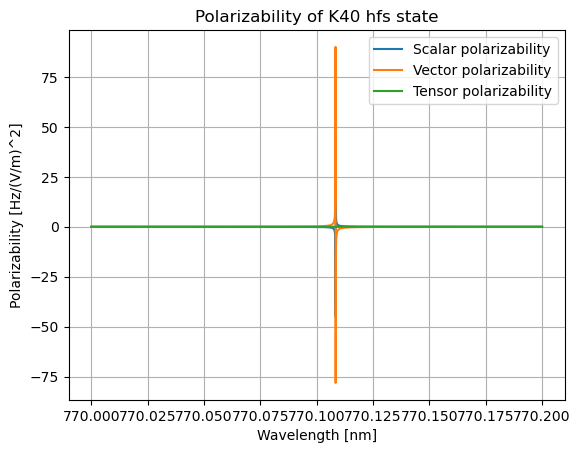

In [6]:
lambdas = np.linspace(770, 770.2, 5000) * u.nm
alpha_s = K40.scalar_hfs_polarizability(lambda_laser=lambdas) # scalar polarizability of the hfs state 
alpha_v = K40.vector_hfs_polarizability(lambda_laser=lambdas) # vector polarizability of the hfs state 
alpha_t = K40.tensor_hfs_polarizability(lambda_laser=lambdas) # tensor polarizability of the hfs state (this is zero for J=1/2 states)

plt.plot(lambdas, alpha_s, label='Scalar polarizability')
plt.plot(lambdas, alpha_v, label='Vector polarizability')
plt.plot(lambdas, alpha_t, label='Tensor polarizability')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Polarizability [Hz/(V/m)^2]')
plt.title('Polarizability of K40 hfs state')
plt.legend()
plt.grid()

In [7]:
# Scalar polarizability of the hfs state at 1064nm
K40.scalar_hfs_polarizability(lambda_laser=1064*u.nm)

<Quantity 1.47766676e-05 m2 Hz / V2>

Now, that we have some beams and an atom, we can define a LaserSetup(). This just takes instances of Beam() or Laser() or a sequence of them and can then calculate the light potential, that the hyperfine atom feels. Note, that a Laser() can have several beams that are interfering with each other. 

Also, LaserSetup() takes an atom or sequence of atoms. If a sequence of atoms is passed, then the potential will be calculated for all of them and a list will be returned with the potential array for each atom.

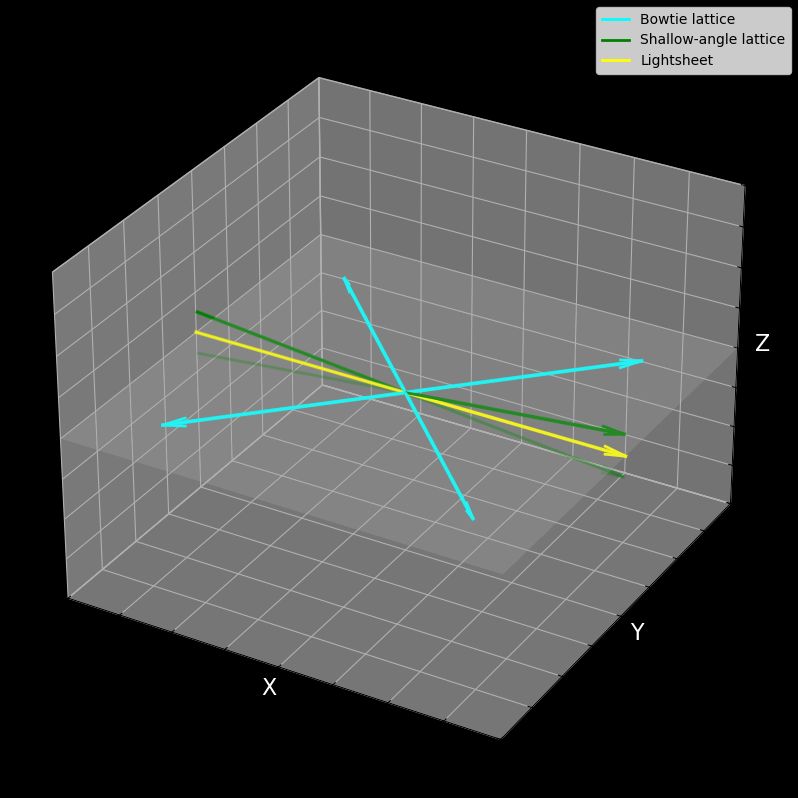

In [8]:
setup = LaserSetup(
    lasers=[lattice_xy, lattice_z, lightsheet], # some beams or lasers
    atoms=K40, # some atoms
)

setup.plot_beams() # we can look at a 3d view showing all the beams in the setup, in our case the lightsheet beam (blue) and the two z-lattice beams (green)

<h3>Calculate potential</h3>
Finally, let us calculate the AC Stark potential! In order for this to be valid, (1) all beams must be at least a couple of linewidths detuned from each fs transition, (2) the beam power must be low enough such that the AC Stark shift is small compared to the hyperfine split (almost always fulfilled), and (3) we assume that the different Zeeman levels are shifted by a bias magnetic field and are also not mixed by the light.

The total light shift of the atom's hyperfine level can be calculated at a single point (x,y,z) or it can be found at multiple positions generated by np.meshgrid() to get a 3d array containing the potential over space evaluated at grid points.

In [9]:
n = 101

x = np.linspace(-1, 1, n) * u.um 
y = np.linspace(-1, 1, n) * u.um
z = np.linspace(-5, 5, n) * u.um # from the inersect angle, we expect a lattice spacing of ~3um, so we need to go further than in x- and y-direction 
                                 # to see the lattice

X, Y, Z = np.meshgrid(x, y, z, indexing='ij') # these are arrays of shape (n,n,n) containing the grid points for our spatial region

V = setup.V(X, Y, Z) # the units of the potential are [h x MHz] and for the meshgrid it is now a 3d array of shape (n,n,n). If we had passed several atoms
                     # when defining the LaserSetup(), we would get a list of len(atoms) containing 3d arrays of shape (n,n,n)

In [10]:
V.unit

Unit("MHz")

In [14]:
interactive_plot(V,x,y,z,title="bowtie lattice z lattice and lightsheet",cbar_title="V[MHz]")

Output()

<h3>Analyse results</h3>

In order to view the potential, we can do an interactive plot. Note, that the lattice spacing along z-direction is ~3um due to the shallow angle and therefore we set the z-axis as [-5, 5]um and the x- and y-axis only as [-1, 1]um!

In the xy-plane, we see the bowtie lattice, which is rotated by 45° with respect to a regular lattice configuration, has a factor sqrt(2) larger lattice spacing and is by a factor 4 deeper. If we slide the z-value, we see how the colorbar changes as we slide through the z-lattice. 

Along z-direction, we see the z-lattice as well as the lightsheet as kind of an envelope. 

In [11]:
interactive_plot(
    V, # 3d data array or list of 3d data arrays to compare different potentials next to each other
    x, y, z, # the grid points for the 3d data array
    title='Bowtie xy-lattice + z-lattice + z-lightsheet',  # title of the plot or list of titles for each plot, if there are several potentials to compare
    cbar_title='V [h x MHz]' # title of the colorbar or list of titles for each colorbar
)

Output()

We can find the depth of the lattice along x-, y-, and z-direction by subtracting the maximum from the minimum at the other directions fixed at 0 (because we can see in the plot that along all 3 directions the maximal depth is at (0,0,0))

In [12]:
from astropy.constants import h, k_B 

depth_x = (np.max(V[:, n//2, n//2]) - np.min(V[:, n//2, n//2])).to(u.MHz) # depth of the lattice in the x-direction at y=z=0 in [h x MHz]
depth_y = (np.max(V[n//2, :, n//2]) - np.min(V[n//2, :, n//2])).to(u.MHz) # depth of the lattice in the y-direction at x=z=0 in [h x MHz]
depth_z = (np.max(V[n//2, n//2, :]) - np.min(V[n//2, n//2, :])).to(u.MHz) # depth of the lattice in the z-direction at x=y=0 in [h x MHz]

print(f'Depth of the lattice in x-direction: {depth_x:.2f} = {(depth_x*h/k_B).to(u.uK):.2f}')
print(f'Depth of the lattice in y-direction: {depth_y:.2f} = {(depth_y*h/k_B).to(u.uK):.2f}')
print(f'Depth of the lattice in z-direction: {depth_z:.2f} = {(depth_z*h/k_B).to(u.uK):.2f}')

Depth of the lattice in x-direction: 20.36 MHz = 977.21 uK
Depth of the lattice in y-direction: 20.36 MHz = 977.22 uK
Depth of the lattice in z-direction: 3.56 MHz = 170.62 uK
